# Rendu Atelier 1: HADJEMI Mohamed El Amine

Avant d'éxecuter mon code faut créer un venv

1 . Création d'un environnement virtuel
python3 -m venv quantum_env


2 . Activation de l'environnement virtuel
source quantum_env/bin/activate

3 . Installation de Qiskit avec le support de visualisation
pip install 'qiskit[visualization]'
pip install qiskit-ibm-runtime
pip install matplotlib
pip install python-dotenv

4 .  Création du venv avec l'api key (je n'ai pas pusher la mienne sur github)

5 . Lancement de jupeter a partir de l'environement quantum_env qu'on a déja crée à l'étape 1


# Étape 1: Création du circuit quantique (Bell state)


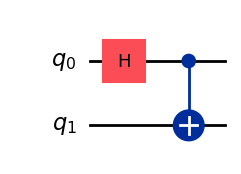

In [8]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

In [3]:
# Set up six different observables.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

In [10]:
from dotenv import load_dotenv
from qiskit_ibm_runtime import QiskitRuntimeService
import os


# Chargement du token depuis le fichier .env
load_dotenv()
token = os.getenv('IBM_QUANTUM_TOKEN')

# Connexion au service IBM Quantum
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

# Étape 2: Optimisation du circuit pour un backend réel


Backend sélectionné: ibm_sherbrooke


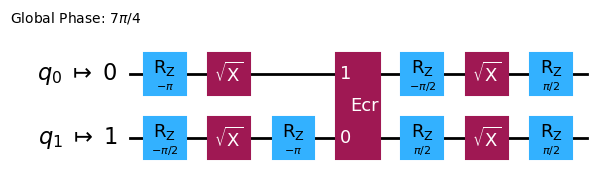

In [5]:
# Utilisez le backend le moins occupé
try:
    backend = service.least_busy(simulator=False, operational=True)
    print(f"Backend sélectionné: {backend.name}")
except:
    # Si aucun backend réel n'est disponible, utilisez un simulateur
    backend = service.backend("ibmq_qasm_simulator")
    print(f"Utilisation du simulateur: {backend.name}")

# Conversion en circuit ISA et observables mappées
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

# Affichage du circuit optimisé (décommentez pour voir dans un notebook)
isa_circuit.draw("mpl", idle_wires=False)

# Étape 3: Exécution avec le primitif Estimator



In [6]:
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# Exécution du job
job = estimator.run([(isa_circuit, mapped_observables)])

# Affichage de l'ID du job
print(f">>> Job ID: {job.job_id()}")

# Attente et récupération des résultats
job_result = job.result()
pub_result = job_result[0]

>>> Job ID: cza0t6rtp60g008h12yg


# Étape 4: Analyse des résultats




Résultats des mesures d'observables:
IZ: -0.0099 ± 0.0146
IX: 0.0029 ± 0.0129
ZI: -0.0183 ± 0.0151
XI: -0.0009 ± 0.0137
ZZ: 0.9966 ± 0.0072
XX: 0.9843 ± 0.0067

Graphique enregistré dans 'bell_state_results.png'

Explication des résultats:
- Pour l'état de Bell (|00⟩ + |11⟩)/√2:
  * Les valeurs moyennes pour IZ, IX, ZI, XI sont proches de 0
  * Les corrélations ZZ et XX sont proches de 1
  * Ces résultats confirment l'intrication quantique entre les qubits


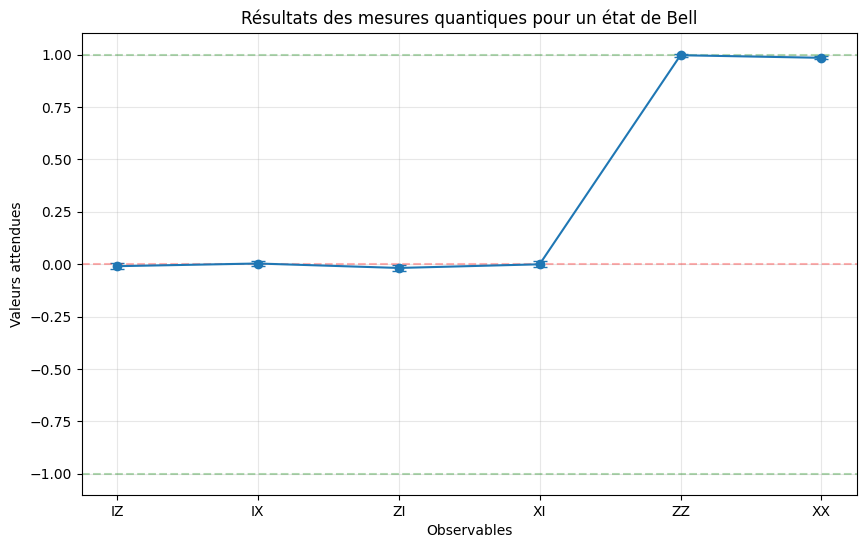

In [7]:
import matplotlib.pyplot as plt

values = pub_result.data.evs
errors = pub_result.data.stds

# Affichage des résultats numériques
print("\nRésultats des mesures d'observables:")
for i, label in enumerate(observables_labels):
    print(f"{label}: {values[i]:.4f} ± {errors[i]:.4f}")

# Création du graphique
plt.figure(figsize=(10, 6))
plt.errorbar(observables_labels, values, yerr=errors, fmt='o-', capsize=5)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.axhline(y=1, color='g', linestyle='--', alpha=0.3)
plt.axhline(y=-1, color='g', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.xlabel('Observables')
plt.ylabel('Valeurs attendues')
plt.title('Résultats des mesures quantiques pour un état de Bell')
plt.savefig('bell_state_results.png')
print("\nGraphique enregistré dans 'bell_state_results.png'")

print("\nExplication des résultats:")
print("- Pour l'état de Bell (|00⟩ + |11⟩)/√2:")
print("  * Les valeurs moyennes pour IZ, IX, ZI, XI sont proches de 0")
print("  * Les corrélations ZZ et XX sont proches de 1")
print("  * Ces résultats confirment l'intrication quantique entre les qubits")